<a href="https://colab.research.google.com/github/VidushiBhatia/Customer-Segmentation/blob/main/Customer_Segmentation_Case_Study_Instacart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end segmentation implementation on [Instacart](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)

## 1. Install Relevant Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.pyplot import plot
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
!pip install kneed
from kneed import KneeLocator
from sklearn.metrics import silhouette_score


## 2. Read Files and Understand Data

   * Read all the files
   * Review Tables to get a sense of the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [17]:
############################################ Helper Function 1 ############################################################
############################################### READ FILES ################################################################

def read_data(path):
  all_dfs = {}
  df = pd.DataFrame()
  files = os.listdir(path) 
  missing_value_formats = ["n.a.","?","NA","n/a", "na", "--","-"]
  
  for file in files:
    if file.endswith('.csv'):
      all_dfs[file[:file.find(".")]] = pd.read_csv(os.path.join(path,file), na_values = missing_value_formats)
  return all_dfs

############################################ Helper Function 2 ############################################################
############################################ SUMMARIZE FILES ##############################################################

def summarize_data(df):
  print("\nOverview")
  display(df.head())
  print("\nSummary")
  display(df.describe(include='all'))
  print("\nNull Values")
  display(df.isnull().sum()/len(df))

In [ ]:
# Understand the available data

path = '/content/drive/MyDrive/instacart-market-basket-analysis/'
all_dfs = read_data(path)

print("\n############################## AISLES ##############################")
summarize_data(all_dfs['aisles'])
print("\n############################## DEPARTMENTS ##############################")
summarize_data(all_dfs['departments'])
print("\n############################## ORDER-PRODUCTS PRIOR ##############################")
summarize_data(all_dfs['order_products__prior'])
print("\n############################## ORDER-PRODUCTS TRAIN ##############################")
summarize_data(all_dfs['order_products__train'])
print("\n############################## ORDERS ##############################")
summarize_data(all_dfs['orders'])
print("\n############################## PRODUCTS ##############################")
summarize_data(all_dfs['products'])
print("\n############################## SAMPLE SUBMISSION ##############################")
summarize_data(all_dfs['sample_submission'])


In [ ]:
# MISSING VALUE TREATMENT

# Checking reason for Missing values and applying apt missing value treatment

all_dfs['orders'].loc[all_dfs['orders']['order_number']==1, 'days_since_prior_order'] = 0
summarize_data(all_dfs['orders'])

<br>

**Overview of Tables**

| Table Name | Column Names | Description | Hypothesis for Data Exploration  |
| --- | --- | --- | --- | 
| aisles | aisle_id, aisle | 134 unique IDs, names for different aisles at Instacart | aisle which generates highest revenue, most frequently used aisle, distribution of<br> aisle usage based on demographics and other customer info, is there a trend of<br> aisle popularity with time of day, day of week, or any specific month of year? |
| departments | department_id, department | 21 unique IDs, names for different departments including 'missing'<br> - looks like the rolled-up metric for aisles e.g. one department might <br> have multiple aisles | revenue by dept, frequency of use by dept, distribution of dept usage based<br> on demographics and other available customer info, dept popularity by time <br>of day, day of week, or any specific month of year  |
| order-products-prior | order_id, product_id, add_to_cart_order, reordered | 32,434,489 rows at order-product level with 3,214,874 unique orders <br>for 49,677 unique products. 'add_to_cart_order' shows the order in which<br> they were added to the cart and 'reordered' | most ordered products, most frequent re-ordered products, products which <br>are only ordered once and not reordered, Number of products in one order,<br> are the products that are ordered together from the same aisle/dept? |
 | order-products-train | order_id, product_id, add_to_cart_order, reordered | Similar to df_prior_orders but only has latest order information. 1,384,617 rows<br> with 131,209 unique order IDs and 39,123  | most ordered products, most frequent re-ordered products, products <br>which are only ordered once and not reordered, Number of products in <br>one order, are the products that are ordered together from the same aisle/dept? |
| orders | order_id, user_id, eval_set,<br> order_number, order_dow,<br> order_hour_of_day, days_since_prior_order | 3,421,083 orders showing information on order ID, user ID, which evaluation<br> dataset the order is in (prior, train, test), day of week, hour of day,<br> days since prior order | Most popular day & time for placing an order, trend of day & time by products |
| products | product_id, product_name, aisle_id, department_id | 49,688 rows mapping products to aisles and departments |	covered in above metrics |

<br>

**Missing Values**

* 6% values are missing for 'days since prior order' in 'orders' df --> Given these are only for Order Number 1, we can replace missing values with '0' days
* No other missing values found in the data
* FYI - We can use Imputers from sklearn in couldn't replace our missing data with 0



## 3. Create a Master Dataset

In [ ]:
# Prior and Train order datasets have the same columns orders from different time frame - These need to be concatenated

master_df = pd.concat([all_dfs['order_products__prior'], all_dfs['order_products__train']]).sort_values(by=['order_id'])

# Merge the rest of the datasets
master_df = pd.merge(left = master_df, right = all_dfs['products'],
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = all_dfs['aisles'],
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = all_dfs['departments'],
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = all_dfs['orders'],
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

col_order = ['user_id','order_id','product_id','aisle_id','department_id','add_to_cart_order',
 'reordered','product_name','aisle','department','eval_set','order_number','order_dow','order_hour_of_day',
 'days_since_prior_order']

master_df = master_df[col_order]

del all_dfs

summarize_data(master_df)

## 4. EDA

In [21]:
# Identify Primary Key
len(master_df.groupby(['user_id','order_id','product_id'], as_index=False).count())

33819106

In [22]:
# Identify unique values in columns
print ("\nNumber of Rows : ", len(master_df))
print ("Unique user_id: ", master_df['user_id'].nunique(),", % :", f"{master_df['user_id'].nunique() / len(master_df): .2%}")
print ("Unique order_id: ", master_df['order_id'].nunique(),", % :", f"{master_df['order_id'].nunique() / len(master_df): .2%}")
print ("Unique product_id: ", master_df['product_id'].nunique(),", % :", f"{master_df['product_id'].nunique() / len(master_df): .2%}")
print ("Unique aisle_id: ", master_df['aisle_id'].nunique(),", % :", f"{master_df['aisle_id'].nunique() / len(master_df): .2%}")
print ("Unique department_id: ", master_df['department_id'].nunique(),", % :", f"{master_df['department_id'].nunique() / len(master_df): .2%}")
print ("Unique add_to_cart_order: ", master_df['add_to_cart_order'].nunique(),", % :", f"{master_df['add_to_cart_order'].nunique() / len(master_df): .2%}")
print ("Unique reordered: ", master_df['reordered'].nunique(),", % :", f"{master_df['reordered'].nunique() / len(master_df): .2%}")
print ("Unique product_name: ", master_df['product_name'].nunique(),", % :", f"{master_df['product_name'].nunique() / len(master_df): .2%}")
print ("Unique aisle: ", master_df['aisle'].nunique(),", % :", f"{master_df['aisle'].nunique() / len(master_df): .2%}")
print ("Unique department: ", master_df['department'].nunique(),", % :", f"{master_df['department'].nunique() / len(master_df): .2%}")
print ("Unique eval_set: ", master_df['eval_set'].nunique(),", % :", f"{master_df['eval_set'].nunique() / len(master_df): .2%}")
print ("Unique order_number: ", master_df['order_number'].nunique(),", % :", f"{master_df['order_number'].nunique() / len(master_df): .2%}")
print ("Unique order_dow: ", master_df['order_dow'].nunique(),", % :", f"{master_df['order_dow'].nunique() / len(master_df): .2%}")
print ("Unique order_hour_of_day: ", master_df['order_hour_of_day'].nunique(),", % :", f"{master_df['order_hour_of_day'].nunique() / len(master_df): .2%}")
print ("Unique days_since_prior_order: ", master_df['days_since_prior_order'].nunique(),", % :", f"{master_df['days_since_prior_order'].nunique() / len(master_df): .2%}")


Number of Rows :  33819106
Unique user_id:  206209 , % :  0.61%
Unique order_id:  3346083 , % :  9.89%
Unique product_id:  49685 , % :  0.15%
Unique aisle_id:  134 , % :  0.00%
Unique department_id:  21 , % :  0.00%
Unique add_to_cart_order:  145 , % :  0.00%
Unique reordered:  2 , % :  0.00%
Unique product_name:  49685 , % :  0.15%
Unique aisle:  134 , % :  0.00%
Unique department:  21 , % :  0.00%
Unique eval_set:  2 , % :  0.00%
Unique order_number:  100 , % :  0.00%
Unique order_dow:  7 , % :  0.00%
Unique order_hour_of_day:  24 , % :  0.00%
Unique days_since_prior_order:  31 , % :  0.00%


In [23]:
# look at the heirarchy of products, aisles and departments

master_df.groupby(['department','aisle','product_name'], as_index = False).size()

,department,aisle,product_name,size
0,alcohol,beers coolers,'Swingtop' Premium Lager,1
1,alcohol,beers coolers,12 Oz Beer,252
2,alcohol,beers coolers,12 Oz Lager,389
3,alcohol,beers coolers,1500 Pale Ale,61
4,alcohol,beers coolers,1664,17
...,...,...,...,...
49680,snacks,trail mix snack mix,Traditional Snack Mix,2327
49681,snacks,trail mix snack mix,Trail Mix,12601
49682,snacks,trail mix snack mix,Tram Bar Peanut Butter Milk Chocolate Trail Mix,7
49683,snacks,trail mix snack mix,Tropical Trail Mix,214


In [24]:
############################################ Helper Function 3 ############################################################
############################################ VISUALIZE DATA ##############################################################

def CreateCharts (ax, data, x, y, chart_type, legend = False, size = 5, hue = None, palette=None):
  if chart_type == "scatter":
      plot = sns.scatterplot(data=data, x=x, y=y, size=size, legend=legend, 
              hue=hue, sizes=(20, 200), palette = palette, ax=ax)
  elif chart_type == "bar":
      plot = sns.barplot(x=x, y=y, data=data, 
              hue=hue, palette = palette, ax=ax, ci="sd")
  elif chart_type == "density":
      plot = sns.kdeplot(x=x, data=data, 
              shade=True, alpha=0.5, ax=ax)  
  elif chart_type == "swarm":
      plot = sns.swarmplot(x=x, y=y, hue=hue, data=data,
                    palette=palette, ax=ax)
  elif chart_type =='hist':
      plot = sns.histplot(data=data, x=x, kde=True, ax = ax, palette = palette )
  return plot

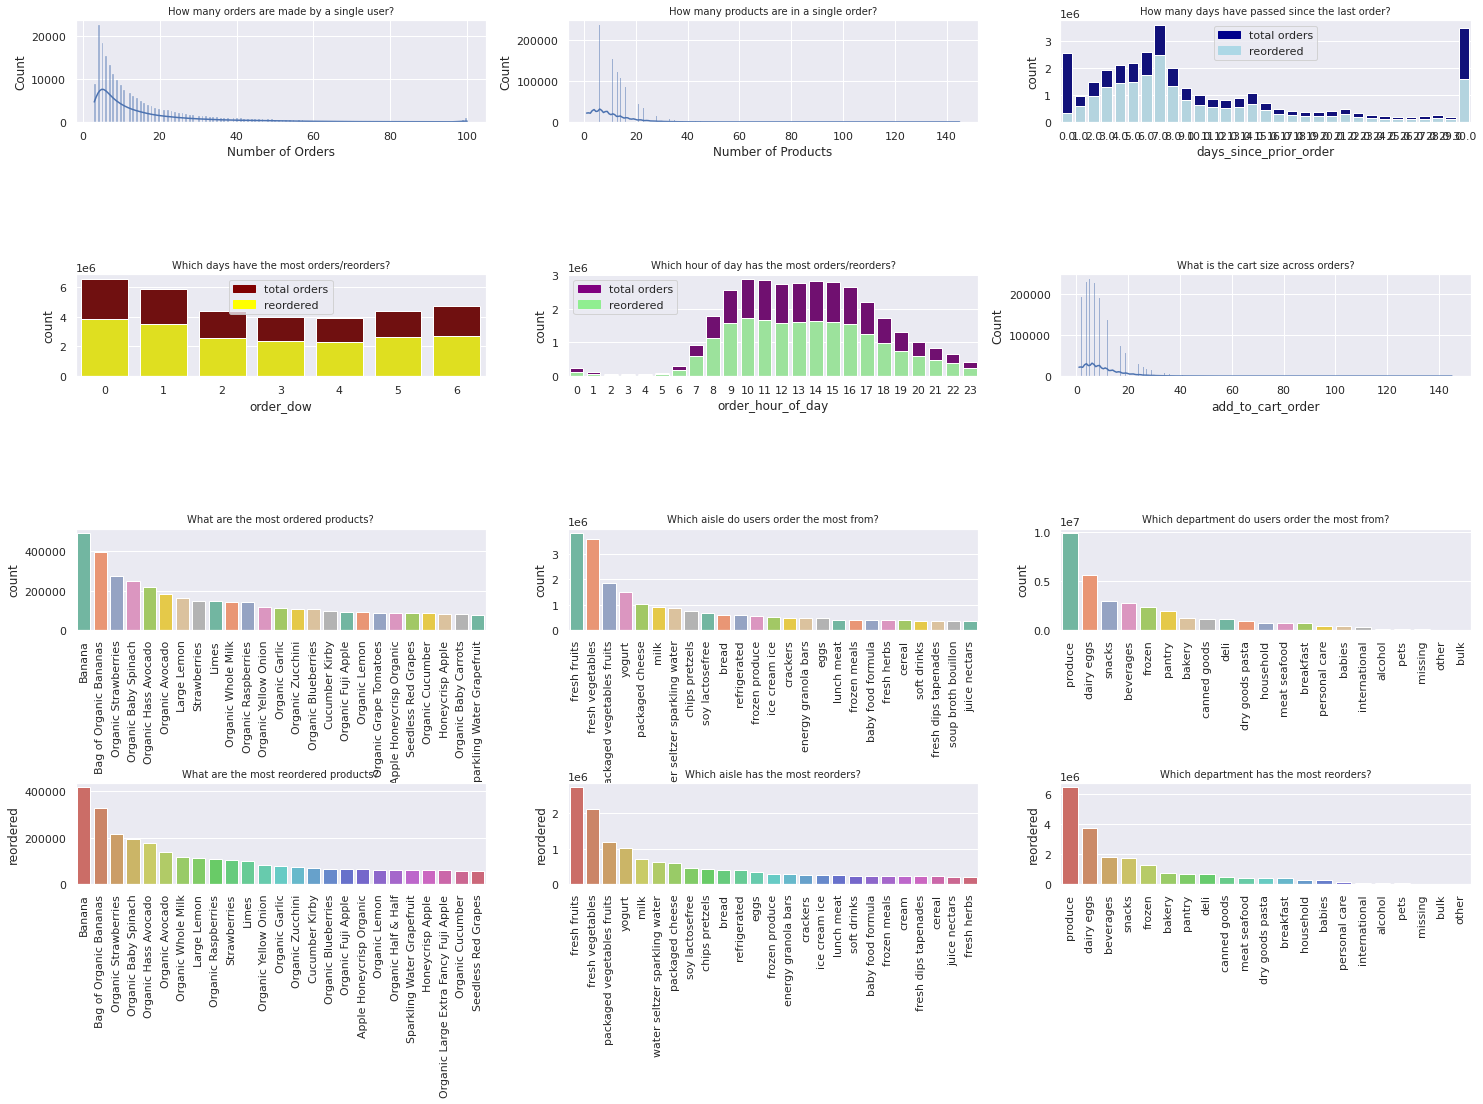

In [25]:

sns.set(style="darkgrid")
fig, ax = plt.subplots(4,3, figsize=(25,15))

# Plot 1
data = master_df[['user_id','order_id']].drop_duplicates().groupby('user_id').size().reset_index(name='Number of Orders').sort_values(by='Number of Orders', ascending=False)
ax[0,0] = CreateCharts(ax[0,0], data, x = "Number of Orders", y=None, chart_type = "hist", palette="bright")
ax[0,0].set_title('How many orders are made by a single user?', fontsize=10)


# Plot 2
data = master_df.groupby('order_id').size().reset_index(name='Number of Products').sort_values(by='Number of Products', ascending=False)
ax[0,1] = CreateCharts(ax[0,1], data, x = "Number of Products", y=None, chart_type = "hist", palette="dark")
ax[0,1].set_title('How many products are in a single order?', fontsize=10)


# Plot 3
import matplotlib.patches as mpatches
data1 = master_df.groupby('days_since_prior_order', as_index=False).size()
bar1 = sns.barplot(x="days_since_prior_order",  y="size", data=data1, color='darkblue', ax=ax[0,2])
data2 = master_df[master_df['reordered']==1].groupby('days_since_prior_order', as_index=False).size()
bar2 = sns.barplot(x="days_since_prior_order",  y="size", data=data2,  color='lightblue', ax=ax[0,2])
top_bar = mpatches.Patch(color='darkblue', label='total orders')
bottom_bar = mpatches.Patch(color='lightblue', label='reordered')
ax[0,2].legend(handles=[top_bar, bottom_bar])
ax[0,2].set_title('How many days have passed since the last order?', fontsize=10)
ax[0,2].set_ylabel('count')


# Plot 4

data1 = master_df.groupby('order_dow', as_index=False).size()
bar1 = sns.barplot(x="order_dow",  y="size", data=data1, color='maroon', ax=ax[1,0])
data2 = master_df[master_df['reordered']==1].groupby('order_dow', as_index=False).size()
bar2 = sns.barplot(x="order_dow",  y="size", data=data2,  color='yellow', ax=ax[1,0])
top_bar = mpatches.Patch(color='maroon', label='total orders')
bottom_bar = mpatches.Patch(color='yellow', label='reordered')
ax[1,0].legend(handles=[top_bar, bottom_bar])
ax[1,0].set_title('Which days have the most orders/reorders?', fontsize=10)
ax[1,0].set_ylabel('count')

# Plot 5
data1 = master_df.groupby('order_hour_of_day', as_index=False).size()
bar1 = sns.barplot(x="order_hour_of_day",  y="size", data=data1, color='purple', ax=ax[1,1])
data2 = master_df[master_df['reordered']==1].groupby('order_hour_of_day', as_index=False).size()
bar2 = sns.barplot(x="order_hour_of_day",  y="size", data=data2,  color='lightgreen', ax=ax[1,1])
top_bar = mpatches.Patch(color='purple', label='total orders')
bottom_bar = mpatches.Patch(color='lightgreen', label='reordered')
ax[1,1].legend(handles=[top_bar, bottom_bar])
ax[1,1].set_title('Which hour of day has the most orders/reorders?', fontsize=10)
ax[1,1].set_ylabel('count')

# Plot 6
data = master_df.groupby('order_id', as_index = False)['add_to_cart_order'].max()
ax[1,2] = CreateCharts(ax[1,2], data, x = "add_to_cart_order", y=None, chart_type = "hist", palette="bright")
ax[1,2].set_title('What is the cart size across orders?', fontsize=10)


# Plot 7
data = master_df.groupby('product_name', as_index = False)['product_id'].count().sort_values(by='product_id', ascending=False)
ax[2,0] = CreateCharts(ax[2,0], data.head(25), "product_name", "product_id", "bar", palette = "Set2")
ax[2,0].set_xticklabels(data.head(25)['product_name'], rotation = 90)
ax[2,0].set_title('What are the most ordered products?', fontsize=10)
ax[2,0].set_xlabel('')
ax[2,0].set_ylabel('count')

# Plot 8
data = master_df.groupby('aisle', as_index = False)['aisle_id'].count().sort_values(by='aisle_id', ascending=False)
ax[2,1] = CreateCharts(ax[2,1], data.head(25), "aisle", "aisle_id", "bar", palette = "Set2")
ax[2,1].set_xticklabels(data.head(25)['aisle'], rotation = 90)
ax[2,1].set_title('Which aisle do users order the most from?', fontsize=10)
ax[2,1].set_xlabel('')
ax[2,1].set_ylabel('count')

# Plot 9
data = master_df.groupby('department', as_index = False)['department_id'].count().sort_values(by='department_id', ascending=False)
ax[2,2] = CreateCharts(ax[2,2], data.head(25), "department", "department_id", "bar", palette = "Set2")
ax[2,2].set_xticklabels(data.head(25)['department'], rotation = 90)
ax[2,2].set_title('Which department do users order the most from?', fontsize=10)
ax[2,2].set_xlabel('')
ax[2,2].set_ylabel('count')


# Plot 10
data = master_df.groupby('product_name', as_index = False)['reordered'].sum().sort_values(by = 'reordered', ascending=False)
ax[3,0] = CreateCharts(ax[3,0], data.head(25),'product_name' , "reordered", "bar", palette = "hls")
ax[3,0].set_xticklabels(data.head(25)['product_name'], rotation = 90)
ax[3,0].set_title('What are the most reordered products?', fontsize=10)
ax[3,0].set_xlabel('')

# Plot 11
data = master_df.groupby('aisle', as_index = False)['reordered'].sum().sort_values(by = 'reordered', ascending=False)
ax[3,1] = CreateCharts(ax[3,1], data.head(25),'aisle' , "reordered", "bar", palette = "hls")
ax[3,1].set_xticklabels(data.head(25)['aisle'], rotation = 90)
ax[3,1].set_title('Which aisle has the most reorders?', fontsize=10)
ax[3,1].set_xlabel('')

# Plot 12
data = master_df.groupby('department', as_index = False)['reordered'].sum().sort_values(by = 'reordered', ascending=False)
ax[3,2] = CreateCharts(ax[3,2], data.head(25),'department' , "reordered", "bar", palette = "hls")
ax[3,2].set_xticklabels(data.head(25)['department'], rotation = 90)
ax[3,2].set_title('Which department has the most reorders?', fontsize=10)
ax[3,2].set_xlabel('')


plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=1.5)

plt.show()

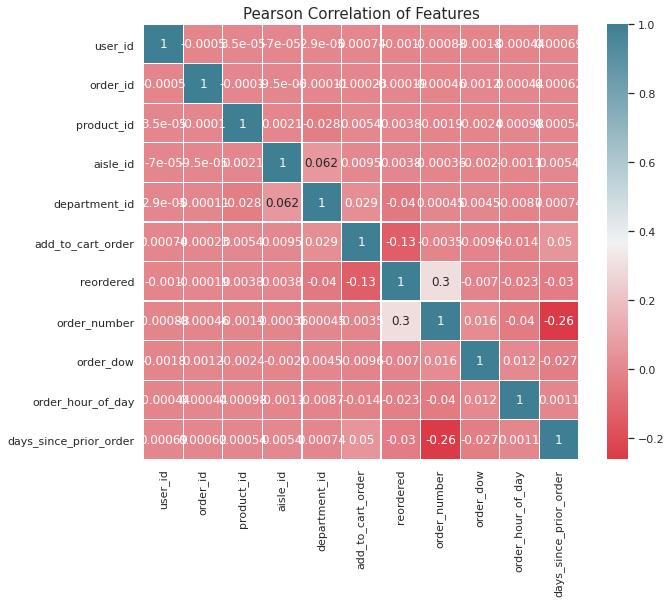

In [26]:
# Correlation
plt.figure(figsize=(10,8))
plt.title('Pearson Correlation of Features', size = 15)
colormap = sns.diverging_palette(10, 220, as_cmap = True)
sns.heatmap(master_df.corr(),
            cmap = colormap,
            square = True,
            annot = True,
            linewidths=0.1,vmax=1.0, linecolor='white',
            annot_kws={'fontsize':12 })
plt.show()

## 5. Feature Engineering

In [27]:
############################################ Helper Function 4 ############################################################
################################################# RUN PCA #################################################################

def run_PCA(data, features, name):
  pca = PCA(n_components=features)
  scale_data = pd.DataFrame(scale(data), columns = data.columns, index = data.index)
  pca_output = pca.fit_transform(data)
  df_pca = pd.DataFrame(data = pca_output, columns = [name+str(i) for i in range(features)], index = data.index)
  plot(pca.explained_variance_ratio_.cumsum(), linewidth=2)
  print("\nImportance of Components")
  print(pd.DataFrame(data = pca.components_, columns = data.columns, index = ['prod_'+str(i) for i in range(features)]))
  return df_pca


Importance of Components
aisle   air fresheners candles  asian foods  ...  white wines    yogurt
prod_0                0.000464     0.020537  ...    -0.000023  0.223725
prod_1                0.001283    -0.008505  ...     0.001193  0.550046
prod_2                0.001187     0.015831  ...     0.001847  0.659729
prod_3               -0.006602    -0.028403  ...    -0.010020  0.425199
prod_4                0.000087    -0.001246  ...     0.001428 -0.096026
prod_5               -0.002983    -0.018950  ...    -0.005988  0.056591
prod_6                0.001726     0.011288  ...    -0.000044 -0.075255
prod_7               -0.002450     0.005900  ...    -0.009345  0.031028
prod_8                0.000569    -0.009678  ...     0.000476 -0.034955
prod_9               -0.006837    -0.019379  ...    -0.006639 -0.075275

[10 rows x 134 columns]


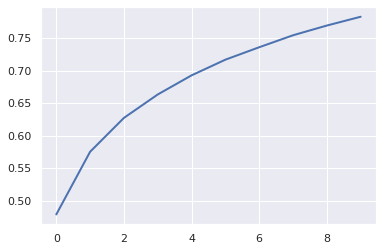

In [28]:
# PCA to find product preference
prod_pref = pd.pivot_table(master_df.groupby(['user_id','aisle'], as_index=False).size(), values='size', index='user_id',
                    columns=['aisle'], aggfunc=np.sum, fill_value=0)
prod_pref = run_PCA(prod_pref, 10, "prod_pref")

# PCA to find day preference
# day_pref = pd.pivot_table(master_df, values = 'order_dow', index = 'user_id',
#                columns = ['department'], aggfunc=np.median, fill_value=-1)

# day_pref = run_PCA(day_pref, 10, "day_pref")

In [ ]:
dept_pref = pd.pivot_table(master_df.groupby(['user_id','department'], as_index=False).size(), values='size', index='user_id',
                    columns=['department'], aggfunc=np.sum, fill_value=0)
dept_pref['total'] = dept_pref.sum(axis = 1)

for dept in dept_pref.columns:
  dept_pref[dept+'_perc'] = dept_pref[dept] / dept_pref['total']

dept_pref

In [ ]:
# Create features to demonstrate trend of products prefered by users
model_input = prod_pref.merge(dept_pref, how='left', on='user_id')
# Create features to demonstrate trends of orders made by users
model_input = model_input.merge(master_df.groupby('user_id', as_index = False).agg(
              {'order_id':'count',
               'product_id':'count',
               'days_since_prior_order':'mean',
               'add_to_cart_order':'median',
               }).rename(
              columns={'order_id':'total_orders',
                       'product_id':'total_products',
                       'days_since_prior_order':'mean_days_since_prior_order',
                       'add_to_cart_order':'median_cart_size'}),
               how='left', on='user_id') 
model_input = model_input.set_index('user_id') 
model_input

In [ ]:
## Make data suitable for chosen model
import warnings
warnings.filterwarnings('ignore')

# check for outliers 
for col in model_input.columns:
  cap_val =  (np.mean(model_input[col]) + 3*np.std(model_input[col]))
  model_input[col+"_capped"] = 0
  model_input[col+"_capped"][model_input[col] >= 0 ] = np.minimum(cap_val,model_input[col][model_input[col] >= 0 ])
  model_input[col+"_capped"][model_input[col] < 0 ] = np.maximum((-1)*cap_val,model_input[col][model_input[col] < 0 ])
  print("\nOutliers", col)
  print ("cap: ", cap_val)
  print ("capped positive:", sum (model_input[col][model_input[col] >= 0 ] > cap_val))
  print ("capped negative:", sum (model_input[col][model_input[col] < 0 ] < (-1)*cap_val))


# normalize data
scaler = StandardScaler()
model_input_scaled = pd.DataFrame(scaler.fit_transform(model_input),columns = model_input.columns, index = model_input.index)

In [ ]:
print(dept_pref.columns)

In [60]:
# final dataset

X = model_input_scaled[['prod_pref0_capped',
       'prod_pref1_capped', 'prod_pref2_capped', 'prod_pref3_capped',
       'prod_pref4_capped', 'prod_pref5_capped', 'prod_pref6_capped', 
       'prod_pref7_capped', 'prod_pref8_capped', 'prod_pref9_capped',
       'alcohol_perc', 'babies_perc', 'bakery_perc', 'beverages_perc',
       'breakfast_perc', 'bulk_perc', 'canned goods_perc', 'dairy eggs_perc',
       'deli_perc', 'dry goods pasta_perc', 'frozen_perc', 'household_perc',
       'international_perc', 'meat seafood_perc', 'missing_perc', 'other_perc',
       'pantry_perc', 'personal care_perc', 'pets_perc', 'produce_perc',
       'snacks_perc', 'total_orders_capped',
       'total_products_capped', 'mean_days_since_prior_order_capped',
       'median_cart_size_capped']]

# sns.pairplot(X)

## 6. Modeling - k-means Clustering

Text(0, 0.5, 'SSE')

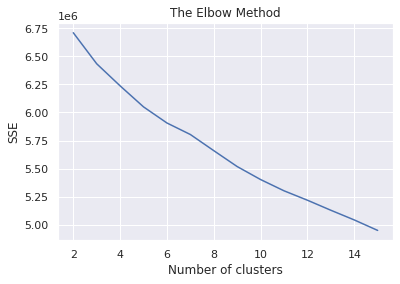

In [74]:
# # find the right number of clusters - Elbow Method

cluster_range = range(2,16)

kmeans_kwargs = {
      "init": "random",
      "n_init": 10,
      "max_iter": 300,
      "random_state": 42,
    }
   
# A list holds the SSE values for each k
sse = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(cluster_range,sse)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


In [92]:
kl = KneeLocator(
    cluster_range, sse, curve="convex", direction="decreasing")

kl.knee

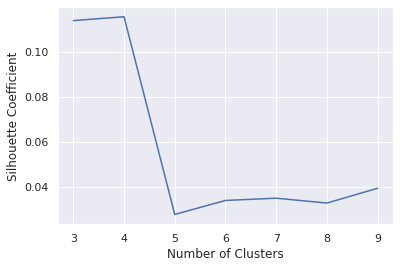

In [77]:
# # find the right number of clusters - Silhouette Score Method

# silhouette_coefficients = []
# cluster_range = range(3,10)

# for k in cluster_range:
#      kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#      kmeans.fit(X)
#      score = silhouette_score(X, kmeans.labels_)
#      silhouette_coefficients.append(score)

# plt.plot(cluster_range, silhouette_coefficients)
# plt.xticks(cluster_range)
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Coefficient")
# plt.show()

In [91]:
# run model
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
kmeans.fit(X)
print("\nClusters",n_clusters)
print("\nsse",kmeans.inertia_)
print("\nIterations it took to converge: ", kmeans.n_iter_)
# print("\ncentroid locations: ",kmeans.cluster_centers_)
model_input['segment_'+str(n_clusters)] = kmeans.labels_
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
kmeans.fit(X)
print("\nClusters",n_clusters)
print("\nsse",kmeans.inertia_)
print("\nIterations it took to converge: ", kmeans.n_iter_)
# print("\ncentroid locations: ",kmeans.cluster_centers_)
model_input['segment_'+str(n_clusters)]= kmeans.labels_
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
kmeans.fit(X)
print("\nClusters",n_clusters)
print("\nsse",kmeans.inertia_)
print("\nIterations it took to converge: ", kmeans.n_iter_)
# print("\ncentroid locations: ",kmeans.cluster_centers_)
model_input['segment_'+str(n_clusters)]= kmeans.labels_

model_output = model_input

## 7. Profiling

In [ ]:
# clean our irrelavant datasets

df_list = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(df_list)
del model_input
del data
del data1
del data2
# del day_pref
del model_input_scaled
del prod_pref
del X
del _9
df_list = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(df_list)


In [82]:
# create master dataset with output
master_df = master_df.merge(model_output[['total_orders_capped',
       'total_products_capped', 'mean_days_since_prior_order_capped',
       'median_cart_size_capped',
        'alcohol_perc', 'babies_perc', 'bakery_perc', 'beverages_perc',
       'breakfast_perc', 'bulk_perc', 'canned goods_perc', 'dairy eggs_perc',
       'deli_perc', 'dry goods pasta_perc', 'frozen_perc', 'household_perc',
       'international_perc', 'meat seafood_perc', 'missing_perc', 'other_perc',
       'pantry_perc', 'personal care_perc', 'pets_perc', 'produce_perc',
       'snacks_perc',
        'segment_5', 'segment_4', 'segment_3','segment_7', 'segment_8', 'segment_9']],
        how='left', on='user_id')

In [ ]:
master_df

In [ ]:
# Distribution with other segments (K+1, K-1)
display(pd.crosstab(master_df['segment_5'], master_df['segment_4'], margins = False).apply(lambda r: round(r/r.sum(), 2), axis=1))
pd.crosstab(master_df['segment_5'], master_df['segment_3'], margins = False).apply(lambda r: round(r/r.sum(), 2), axis=1)

In [84]:
def SegmentSummary(n):
  segment = 'segment_'+str(n)
  fig, ax = plt.subplots(1,n, figsize=(22,3))
  
  data = master_df.groupby([segment, 'aisle'], as_index = False).size().sort_values(by='size', ascending=False)
  for i in range(n):
    ax[i] = CreateCharts(ax[i], data[data[segment]==i].head(5), "aisle", "size", "bar", legend=False, size=None,hue=None, palette = "dark")
    ax[i].set_xticklabels(data[data[segment]==i].head(5)['aisle'], rotation = 90)
    ax[i].set_xlabel('')
    ax[i].set_title('Segment '+str(i), fontsize=10)
    ax[i].set_ylabel('')
  plt.show()
  
  fig, ax = plt.subplots(1,n, figsize=(22,3))
  data = master_df.groupby([segment, 'department'], as_index = False).size().sort_values(by='size', ascending=False)
  for i in range(n):
    ax[i] = CreateCharts(ax[i], data[data[segment]==i].head(5), "department", "size", "bar", legend=False, size=None,hue=None, palette = "Set2")
    ax[i].set_xticklabels(data[data[segment]==i].head(5)['department'], rotation = 90)
    ax[i].set_xlabel('')
    ax[i].set_title('Segment '+str(i), fontsize=10)
    ax[i].set_ylabel('')
  plt.show()  

  summary = master_df.groupby(segment, as_index = False).agg(
              { segment: 'count', 
                'reordered':'sum',
               'order_dow': 'median',
               'order_hour_of_day':'median',
               'days_since_prior_order': 'median',
               'total_orders_capped': ['sum', 'mean'],
               'total_products_capped': ['sum','mean'],
               'mean_days_since_prior_order_capped':'mean',
               'median_cart_size_capped':'median',
               }).astype(float)

  summary['n_size_perc'] = [round(i/sum(summary[segment]['count']),2) for i in summary[segment]['count']]
  summary['reordered_perc'] = [round(i/sum(summary['reordered']['sum']),2) for i in summary['reordered']['sum']]
  summary['total_orders_capped_perc'] = [round(i/sum(summary['total_orders_capped']['sum']),2) for i in summary['total_orders_capped']['sum']]
  summary['total_products_capped_perc'] = [round(i/sum(summary['total_products_capped']['sum']),2) for i in summary['total_products_capped']['sum']]
  display(summary)
  return summary

In [ ]:
from google.colab import files
master_df.to_csv("master_df.csv")
files.download('master_df.csv')

In [ ]:
pd.options.display.float_format = '{:,}'.format
summary_9 = SegmentSummary(9)
summary_8 = SegmentSummary(8)
summary_7 = SegmentSummary(7)
summary_5 = SegmentSummary(5)
summary_4 = SegmentSummary(4)
summary_3 = SegmentSummary(3)